In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from IPython import display
from collections import Counter
from matplotlib import pyplot as plt
from mxnet import autograd, nd, init as ginit, random as mx_random
from scipy.stats import pearsonr, kendalltau, spearmanr, pointbiserialr
from mxnet.gluon import nn, Block, loss as gloss, data as gdata, Trainer as gTrainer
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
mx_random.seed(1)

In [3]:
ziroom_rooms = pd.read_csv('ziroom_rental_dataset.csv')

In [4]:
ziroom_rooms

,is_first_signed,tag_拿铁4.0,tag_独立阳台,tag_智能锁,tag_离地铁近,id,has_video,has_3d,turn,sort_score,bedroom,floor_total,sale_price,parlor,air_quality,face_南,sale_status_3,area_order,floor,floor_ratio,to_station,have_lift,price,build_year,build_type_塔楼,heating_type_集体供暖,total_houses,green_ratio,config_椅子,config_书架,config_桌子,bed_width,config_床垫,wardrobe,config_空调,bed_counter,sofa_size,activity_信用免押,activity_海燕计划,activity_惠蕾计划,tag_布丁4.0,face_西,build_type_板楼,config_路由器,tag_深呼吸1.0,config_智能锁,face_东,tag_木棉4.0,face_北,tag_米苏4.0,sale_status_1,sale_status_0,build_type_塔板结合,config_电视,build_type_未知,config_茶几,tag_绿化率高,heating_type_独立供暖,heating_type_壁挂炉,config_电暖气,tag_米苏3.0,tag_布丁3.0,heating_type_中央供暖,tag_独立卫生间,tag_木棉3.0,tag_原味4.0,config_电视柜,config_空调扇,tag_布丁6.0,config_鞋柜,config_书柜,config_油烟机,config_洗衣机,config_电磁炉,config_热水器,config_微波炉,config_冰箱,tag_4.0,tag_米苏6.0,tag_优格,tag_优格4.0,tag_拿铁3.0,config_床头柜,tag_拿铁6.0,tag_深呼吸2.0,tag_智能空净,config_智能窗帘,tag_燕窝4.0,tag_木棉6.0,config_浴霸,tag_清语,tag_清语4.0,heating_type_无供暖,config_壁挂炉,config_机顶盒,config_热水壶,config_台式燃气灶,tag_拿铁2.0,config_嵌入式燃气灶,activity_限时优惠,tag_布丁5.0,tag_共享客厅,tag_智能新风
0,0,1.0,1.0,1.0,1.0,629502227,0,0,0,8.248,3,16,103977,1,0,1.0,1.0,15.00,1,0.062500,402,1,8.196988,24.0,1.0,1.0,11.0,30.0,2.0,1.0,2.0,1.5,1.0,2.0,1.0,1.5,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,1.0,1.0,731917559,0,0,0,7.831,2,3,88869,1,0,0.0,1.0,11.57,3,1.000000,643,0,8.048788,34.0,0.0,1.0,9.0,20.0,1.0,0.0,1.0,1.5,1.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,1.0,1.0,1.0,770111115,1,0,0,7.914,3,6,111590,1,2,1.0,1.0,15.40,1,0.166667,461,0,8.291547,35.0,0.0,1.0,3.0,35.0,1.0,0.0,2.0,1.5,1.0,3.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,1.0,1.0,1.0,634332692,0,0,0,7.488,3,6,105961,1,0,0.0,1.0,14.20,1,0.166667,216,0,8.224164,45.0,1.0,1.0,10.0,30.0,2.0,1.0,3.0,1.5,1.0,2.0,2.0,1.5,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,1.0,636737456,0,0,0,7.069,3,5,96890,1,0,0.0,1.0,7.15,2,0.400000,748,0,7.948032,25.0,0.0,1.0,8.0,20.0,3.0,0.0,1.0,1.1,1.0,2.0,3.0,1.5,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10407,0,0.0,1.0,1.0,0.0,746828496,0,0,1,0.000,5,20,67025,1,0,1.0,0.0,13.50,16,0.800000,1356,1,8.016318,3.0,0.0,1.0,15.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [5]:
ziroom_rooms.dtypes

is_first_signed        int64
tag_拿铁4.0            float64
tag_独立阳台             float64
tag_智能锁              float64
tag_离地铁近             float64
id                     int64
has_video              int64
has_3d                 int64
turn                   int64
sort_score           float64
bedroom                int64
floor_total            int64
sale_price             int64
parlor                 int64
air_quality            int64
face_南               float64
sale_status_3        float64
area_order           float64
floor                  int64
floor_ratio          float64
to_station             int64
have_lift              int64
price                float64
build_year           float64
build_type_塔楼        float64
heating_type_集体供暖    float64
total_houses         float64
green_ratio          float64
config_椅子            float64
config_书架            float64
config_桌子            float64
bed_width            float64
config_床垫            float64
wardrobe             float64
config_空调     

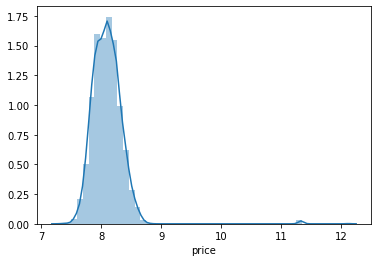

In [6]:
sns.distplot(ziroom_rooms['price'])

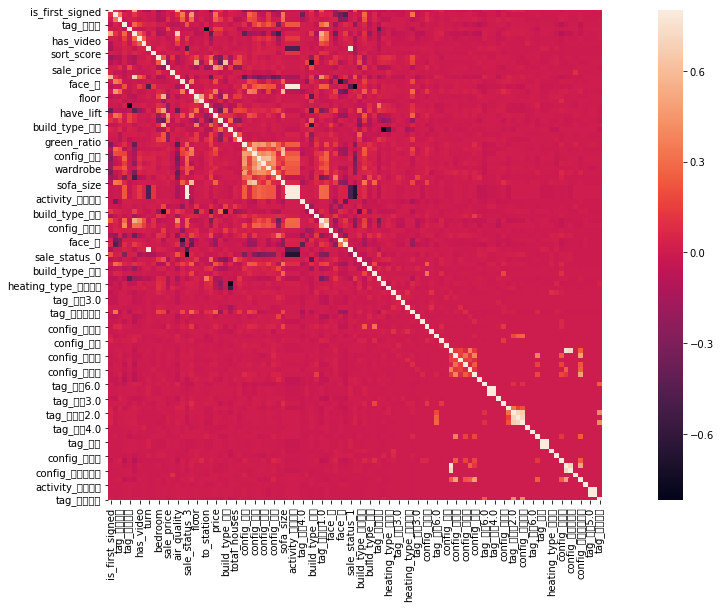

In [8]:
corrmat = ziroom_rooms.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=0.8, square=True)

In [9]:
corrmat['price'].sort_values()
# 最相关的特征: 面积, 售价, 独立阳台, 独立卫生间, 装修风格, 还有 沙发的大小???
# 南北朝向, 影响明显
# 米苏和拿铁风格, 影响明显
# 合租室友, 和 价格负相关
# 建造年份和 到地铁站的距离, 相关性和日常理解的不一样
# 没想到供暖方式影响也大

tag_米苏4.0           -0.216831
face_北              -0.204354
to_station          -0.189750
bedroom             -0.177535
tag_绿化率高            -0.140483
heating_type_独立供暖   -0.073907
tag_布丁4.0           -0.070537
build_type_塔板结合     -0.058457
heating_type_壁挂炉    -0.054162
bed_counter         -0.045973
build_type_未知       -0.040050
have_lift           -0.034876
green_ratio         -0.031324
tag_木棉4.0           -0.028450
tag_木棉3.0           -0.022157
floor_ratio         -0.022077
build_type_板楼       -0.016266
tag_布丁3.0           -0.013005
config_台式燃气灶        -0.012750
tag_燕窝4.0           -0.011689
tag_拿铁3.0           -0.010727
sale_status_0       -0.009789
face_西              -0.007949
config_路由器          -0.007802
floor               -0.007566
tag_木棉6.0           -0.007472
config_热水壶          -0.006143
sale_status_1       -0.005678
turn                -0.005678
config_书柜           -0.004389
tag_4.0             -0.004387
tag_智能新风            -0.003706
config_油烟机          -0.002895
config_壁挂炉

In [10]:
sum(ziroom_rooms['sofa_size'] == 0)

8315

In [11]:
def pre_process(dataset, label='price'):
    m, n = dataset.shape
    split_inx = int(m * 0.8)
    dataset = dataset.sample(frac=1).reset_index(drop=True)
    del dataset['id']
    dataset = dataset.astype('float32')
    num_index = dataset.index
    train_y = nd.array(dataset['price'][:split_inx])
    test_y = nd.array(dataset['price'][split_inx:])
    del dataset['price']
    dataset = dataset.apply(lambda x: (x - x.mean()) / x.std())
    train_X = nd.array(dataset[:split_inx])
    test_X = nd.array(dataset[split_inx:])
    return train_X, train_y, test_X, test_y

In [12]:
train_X, train_y, test_X, test_y = pre_process(ziroom_rooms)

In [13]:
train_X


[[-0.568894   -0.62248653 -0.6494467  ... -0.00980015 -0.00980015
  -0.00980015]
 [ 1.7576277  -0.62248653 -0.6494467  ... -0.00980015 -0.00980015
  -0.00980015]
 [-0.568894   -0.62248653  1.5396241  ... -0.00980015 -0.00980015
  -0.00980015]
 ...
 [ 1.7576277  -0.62248653 -0.6494467  ... -0.00980015 -0.00980015
  -0.00980015]
 [-0.568894   -0.62248653 -0.6494467  ... -0.00980015 -0.00980015
  -0.00980015]
 [-0.568894    1.6063063  -0.6494467  ... -0.00980015 -0.00980015
  -0.00980015]]
<NDArray 8329x101 @cpu(0)>

In [14]:
train_y


[7.8359747 7.8972964 8.128585  ... 7.8972964 7.948032  8.119697 ]
<NDArray 8329 @cpu(0)>

In [15]:
# 定义模型 和 损失函数
loss = gloss.L2Loss()

# def get_net(layers=[], drop_prob=[]):
#     net = nn.Sequential()
#     for i, layer in enumerate(layers):
#         if i == len(layers) - 1:
#             net.add(nn.Dense(layer))
#         else:
#             net.add(nn.Dense(layer, activation='relu'))
#         if len(drop_prob) > i:
#             # 测试时关掉 dropout
#             net.add(nn.Dropout(drop_prob[i]))
#     net.initialize(ginit.Normal(sigma=0.01))  
#     return net

class NetWithDropout(Block):
    """
    64 * dopout(0.2) * 1
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden_1 = nn.Dense(64, activation='relu')
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Dense(1)

    def forward(self, x):
        y = self.hidden_1(x)
        if autograd.is_training():
            y = self.dropout(y)
        y = self.out(y)
        return y

net = NetWithDropout()
net.initialize(ginit.Normal(sigma=0.01))

In [16]:
# 定义损失函数
def rmse(net, features, labels):
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds, labels).mean())
    rmse = rmse.asscalar()
    if np.isnan(rmse):
        raise Exception("get loss of NaN")
    return rmse

In [17]:
# 定义训练过程
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, 
          learning_rate, weight_decay, batch_size):
    """
    使用了Adam优化算法
    """
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    trainer = gTrainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_loss = rmse(net, train_features, train_labels)
        train_ls.append(train_loss)
        epoch += 1
        if epoch % 50 == 0:
#             learning_rate = learning_rate * 0.8  # 衰减
            print("Epoch {}: Train loss: {}".format(epoch, train_loss), end='')
        if test_labels is not None:
            test_loss = rmse(net, test_features, test_labels)
            test_ls.append(test_loss)
            if epoch and epoch % 50 == 0:
                print("; Test Loss: {}".format(test_loss), end='')
        if epoch % 50 == 0:
            print('')
    return train_ls, test_ls

In [18]:
layers, drop_probs = [64, 1], [0.2]
k, num_epochs, learning_rate, weight_decay, batch_size = 5, 200, 0.001, 0.005, 20
train_loss, test_loss = train(net, train_X, train_y, None, None, num_epochs, learning_rate, weight_decay, batch_size)
print(np.mean(train_loss[-10:]), np.mean(test_loss[-10:]))

Epoch 50: Train loss: 0.2716439366340637
Epoch 100: Train loss: 0.22150734066963196
Epoch 150: Train loss: 0.25286856293678284
Epoch 200: Train loss: 0.24366536736488342
0.24444902 nan


/Users/zhibin.jiang/Learning/EnvLearning/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zhibin.jiang/Learning/EnvLearning/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
def set_figsize(figsize=(3.5, 2.5)):
    """Change the default figure size"""
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize
    

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    """
    对数 plot: 10^1, 10^-1, 10^-2
    """
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

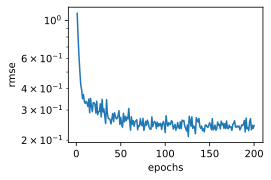

In [20]:
semilogy(range(1, num_epochs + 1), train_loss, 'epochs', 'rmse')  # 如何处理波动

In [21]:
def train_and_pred(lr, wd, num_epochs):
    net.initialize(ginit.Normal(sigma=0.01), force_reinit=True)
    print(net)
    train_ls, _ = train(net, train_X, train_y, None, None, num_epochs, lr, wd, batch_size)
    print("Trainning history: ", train_ls[-10:])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    return generate_submission(net, test_X)
    
def generate_submission(net, test_x):
    preds = np.exp(net(test_x).asnumpy())
#     test_data['RentalPrice'] = pd.Series(preds.reshape(1, -1)[0])
#     submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
#     submission.to_csv('submission_log.csv', index=False)
    return preds

In [ ]:
test_proditions = train_and_pred(learning_rate, weight_decay, int(num_epochs * 2.5))

NetWithDropout(
  (hidden_1): Dense(101 -> 64, Activation(relu))
  (dropout): Dropout(p = 0.2, axes=())
  (out): Dense(64 -> 1, linear)
)
Epoch 50: Train loss: 0.2650246322154999
Epoch 100: Train loss: 0.251785010099411
Epoch 150: Train loss: 0.2484402060508728
Epoch 200: Train loss: 0.24172385036945343
Epoch 250: Train loss: 0.2605365216732025


In [23]:
test_proditions[:10]

array([[4163.7896],
       [3484.2056],
       [2764.8015],
       [3424.7947],
       [2453.5264],
       [2430.005 ],
       [6295.288 ],
       [4298.1753],
       [2719.3127],
       [3029.9956]], dtype=float32)

In [24]:
np.exp(test_y[:10].asnumpy())

array([4159.999 , 2960.0005, 3259.9995, 4230.001 , 2189.9995, 3030.0012,
       5790.0024, 3890.0012, 3189.9985, 2430.0002], dtype=float32)

In [ ]:
test_proditions.shape

In [157]:
nd.exp(test_y).asnumpy()

array([3890.0012, 3729.9983, 4790.002 , ..., 3630.0007, 3529.9998,
       3329.999 ], dtype=float32)

In [171]:
# loss(nd.array(test_proditions), nd.exp(test_y).reshape((1281, 1))).mean()
np.abs(test_proditions.reshape((1281, )) - nd.exp(test_y).asnumpy()).mean(axis=0)

867.4597

In [154]:
loss?

In [89]:
with autograd.predict_mode():
    print(autograd.is_training())

False


In [90]:
with autograd.train_mode():
    print(autograd.is_training())

True


### 他山之石
1. 测试时根据 is-training来 关掉dropout: https://discuss.gluon.ai/t/topic/1278/16
2. 